In [1]:
# pip install statsmodels tensorflow pandas scikit-learn yfinance

In [2]:
# pip install tensorflow

In [3]:
# pip install matplotlib



In [4]:
# import yfinance as yf
# import pandas as pd

# def download_nasdaq100_data(start_date, end_date):

#   # Download the NASDAQ 100 index data
#   nasdaq100 = yf.download("^NDX", start=start_date, end=end_date)

#   return nasdaq100

# if __name__ == "__main__":
#   start_date = "2020-01-01"
#   end_date = "2024-01-01"
#   nasdaq100_data = download_nasdaq100_data(start_date, end_date)
#   nasdaq100_data.to_csv("nasdaq100_data.csv")


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# โหลดข้อมูล OHLC
data = pd.read_csv('data/nasdaq100_data.csv', parse_dates=['Date'])
data = data.dropna()
data.set_index('Date', inplace=True)

# Display the first few rows and general info about the dataset
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1006 non-null   float64
 1   High       1006 non-null   float64
 2   Low        1006 non-null   float64
 3   Close      1006 non-null   float64
 4   Adj Close  1006 non-null   float64
 5   Volume     1006 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.0 KB


(None,
                    Open         High          Low        Close    Adj Close  \
 Date                                                                          
 2020-01-02  8802.219727  8873.629883  8786.900391  8872.219727  8872.219727   
 2020-01-03  8755.169922  8843.650391  8755.169922  8793.900391  8793.900391   
 2020-01-06  8713.889648  8849.980469  8713.889648  8848.519531  8848.519531   
 2020-01-07  8857.139648  8872.469727  8821.679688  8846.450195  8846.450195   
 2020-01-08  8845.450195  8953.549805  8834.940430  8912.370117  8912.370117   
 
                 Volume  
 Date                    
 2020-01-02  2862700000  
 2020-01-03  2586520000  
 2020-01-06  2810450000  
 2020-01-07  2381740000  
 2020-01-08  2472620000  )

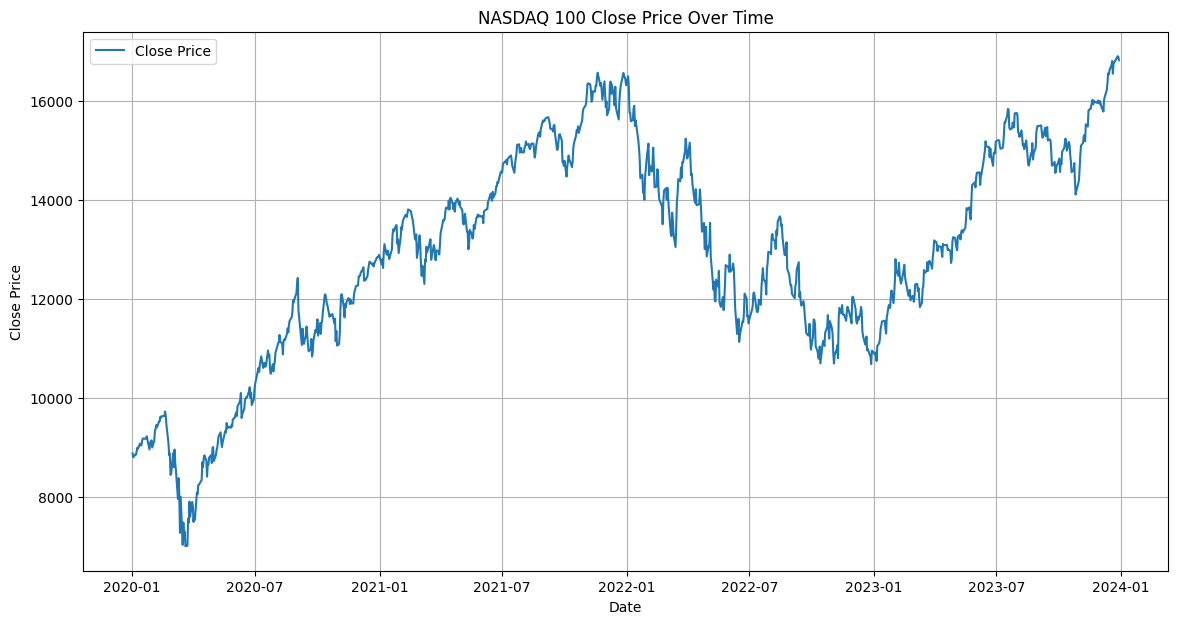

In [6]:
import matplotlib.pyplot as plt


# Plot the Close price over time
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title('NASDAQ 100 Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


## ARIMA model


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('data/nasdaq100_data.csv')

# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter data to the specified end date
start_date = '2021-01-03'
end_date = '2023-12-29'
data_filtered = data.loc[start_date:end_date]

# Extract the prices (assuming a column named 'Close')
prices = data_filtered['Close'].values

# Train/Test split (80% train, 20% test)
train_size = int(len(prices) * 0.8)
train_data, test_data = prices[:train_size], prices[train_size:]

# Use auto_arima with better seasonal handling
model = auto_arima(train_data, start_p=1, start_q=1,
                   max_p=5, max_q=5, seasonal=True, m=15,  # Adjust m based on seasonality
                   stepwise=True, trace=True, error_action='ignore',
                   suppress_warnings=True, d=1, D=1, max_D=2,
                   information_criterion='aic')

# Summary of the model
print(model.summary())

# Fit the model on the train data
model_fit = model.fit(train_data)

# Forecast for the test period
forecast = model_fit.predict(n_periods=len(test_data))



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[15]             : AIC=inf, Time=3.13 sec
 ARIMA(0,1,0)(0,1,0)[15]             : AIC=8375.696, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[15]             : AIC=8216.273, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[15]             : AIC=inf, Time=1.35 sec
 ARIMA(1,1,0)(0,1,0)[15]             : AIC=8376.946, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[15]             : AIC=8132.828, Time=0.82 sec
 ARIMA(1,1,0)(2,1,1)[15]             : AIC=inf, Time=3.36 sec
 ARIMA(1,1,0)(1,1,1)[15]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(2,1,0)[15]             : AIC=8132.362, Time=0.73 sec
 ARIMA(0,1,0)(1,1,0)[15]             : AIC=8215.054, Time=0.29 sec
 ARIMA(0,1,0)(2,1,1)[15]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(1,1,1)[15]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[15]             : AIC=8132.679, Time=0.92 sec
 ARIMA(1,1,1)(2,1,0)[15]             : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(2,1,0)[15] intercept   : AIC=8134.360, T

 - ADF Statistic: The more negative, the stronger the evidence that the data is stationary.
 - p-value: If it’s less than 0.05, the data is likely stationary.

### Check Stationarity with the Augmented Dickey-Fuller (ADF) Test

In [8]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The data is stationary")
    else:c
        print("The data is not stationary")

check_stationarity(train_data)

ADF Statistic: -1.7627233184610267
p-value: 0.3991191796642898
The data is not stationary


### Using ACF and PACF to Determine ARIMA Parameters
##### ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) help you decide the ARIMA parameters:
- p (AR): The number of lag observations included in the model (based on PACF).
- d (Differencing): The number of times the data is differenced to make it stationary.
- q (MA): The size of the moving average window (based on ACF).


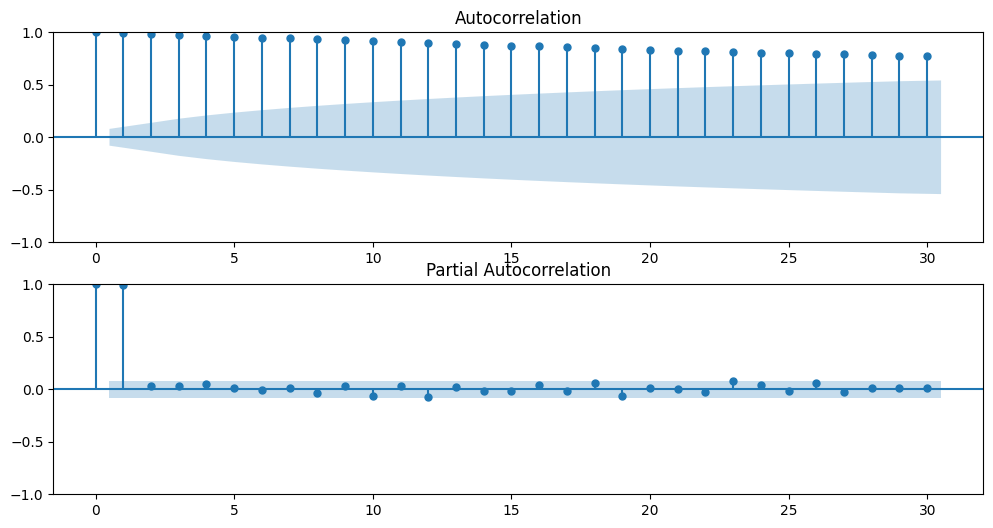

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(train_data, lags=30, ax=plt.gca())
plt.subplot(212)
plot_pacf(train_data, lags=30, ax=plt.gca())
plt.show()


### Model Diagnostics and Tuning


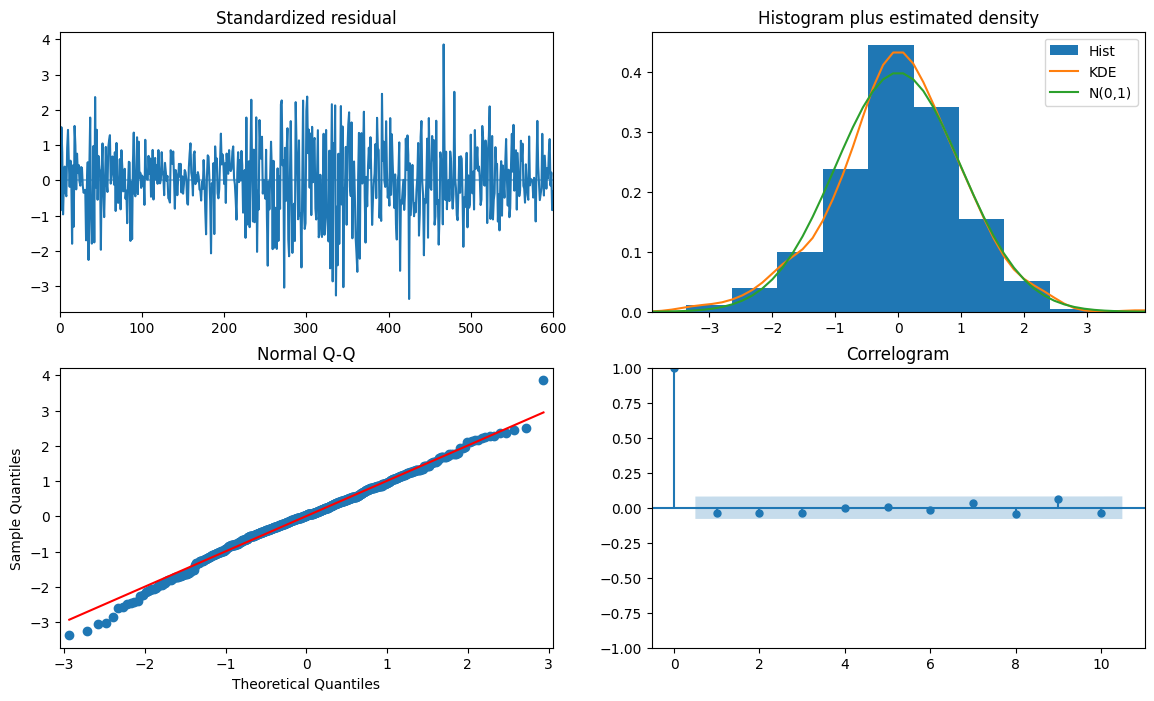

In [11]:
model.plot_diagnostics(figsize=(14, 8))
plt.show()

##### This plot will show:
- Standardized Residuals: Should be normally distributed.
- ACF of Residuals: Should show no significant autocorrelation (random noise).
- Q-Q Plot: Residuals should follow a straight line (normal distribution).

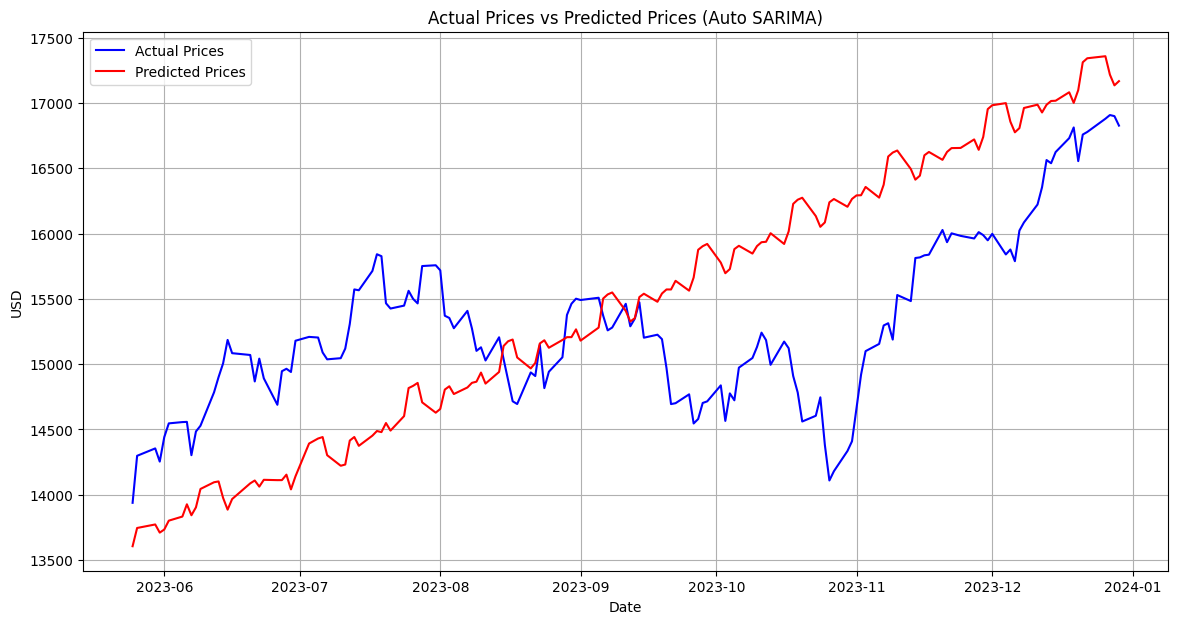

In [12]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(data_filtered.index[-len(test_data):], test_data, label='Actual Prices', color='blue')
plt.plot(data_filtered.index[-len(forecast):], forecast, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Actual Prices vs Predicted Prices (Auto SARIMA)')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
# Calculate the Mean Squared Error
mse = mean_squared_error(test_data, forecast)
print(f"Mean Squared Error: {mse}")
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error: 764961.8480121645
Root Mean Squared Error (RMSE): 874.6209739150809


## LSTM model


C:\Users\wibun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1019
Epoch 2/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 3/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 4/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 5/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


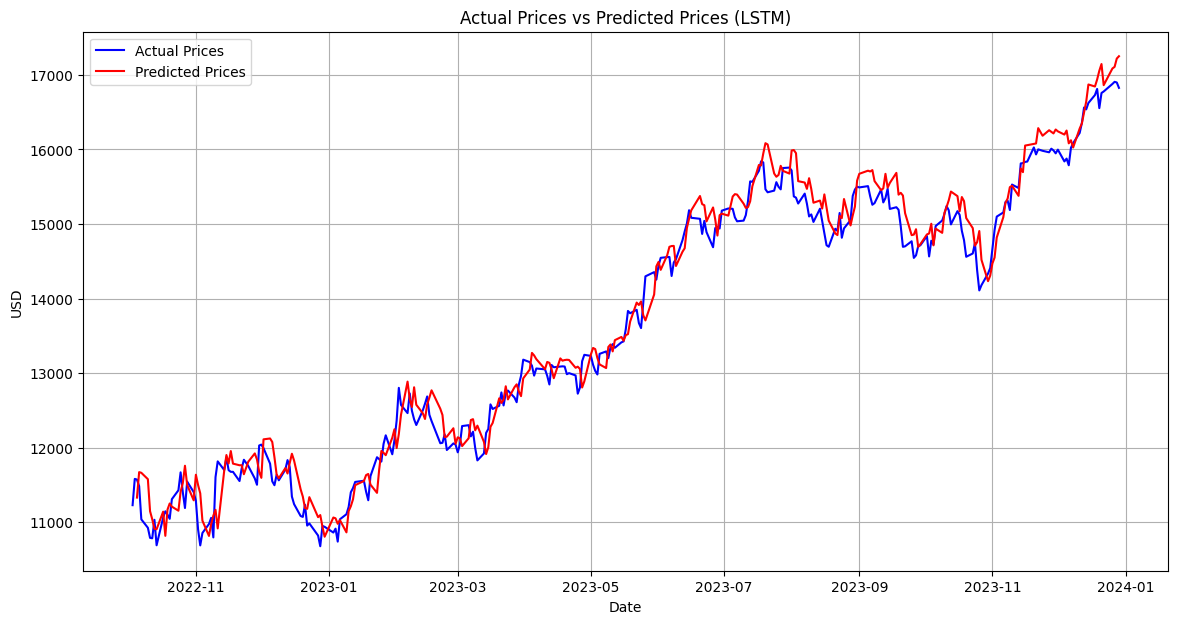

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# start_date,end_date
start_date = '2022-10-02'
end_date = '2023-12-29'

# Load the dataset
data = pd.read_csv('data/nasdaq100_data.csv')

# Convert date column to datetime (assuming a column named 'Date')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data_filtered = data.loc[start_date:end_date]

# Extract the prices (assuming a column named 'Price')
actual_prices = data_filtered['Close'].values.reshape(-1, 1)

# Scale the prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(actual_prices)

# Define a function to create the dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time steps
time_step = 1
X, y = create_dataset(scaled_prices, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, batch_size=1, epochs=5)

# Predicting future prices
lstm_predictions = model.predict(X)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(data_filtered.index, actual_prices, label='Actual Prices', color='blue')
plt.plot(data_filtered.index[time_step+1:], lstm_predictions, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Actual Prices vs Predicted Prices (LSTM)')
plt.grid(True)
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error

# Ensure both arrays have the same length
min_length = min(len(actual_prices), len(lstm_predictions))
actual_prices = actual_prices[:min_length]
lstm_predictions = lstm_predictions[:min_length]

# Calculate and print the Mean Squared Error
mse = mean_squared_error(actual_prices, lstm_predictions)
print(f"Mean Squared Error: {mse}")

# Ensure the lengths match
min_length = min(len(lstm_predictions), len(actual_prices))
lstm_predictions = lstm_predictions[:min_length]
actual_prices = actual_prices[:min_length]
# Calculate RMSE
rmse = np.sqrt(np.mean((lstm_predictions - actual_prices) ** 2))
print(f'Root Mean Squared Error: {rmse}')


Mean Squared Error: 24881.37441352096
Root Mean Squared Error: 157.73830991081704


## RandomForest


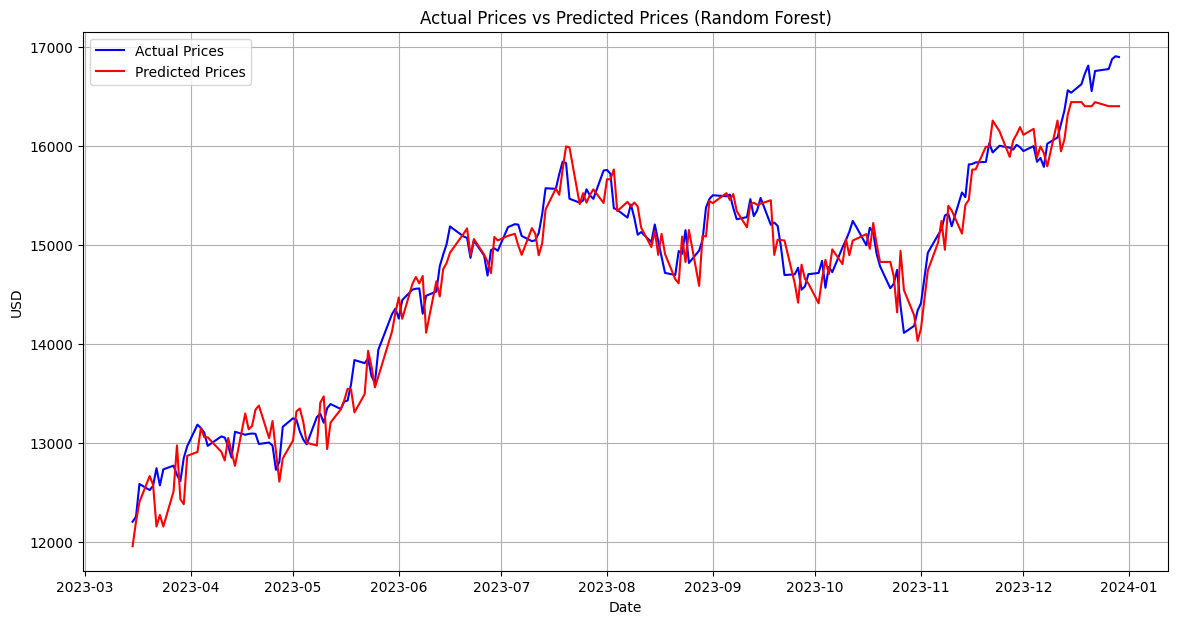

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# start_date,end_date
start_date = '2022-01-02'
end_date = '2023-12-29'

# Load the dataset
data = pd.read_csv('data/nasdaq100_data.csv')


# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data_filtered = data.loc[:end_date]

# Extract the prices (assuming a column named 'Close')
actual_prices = data_filtered['Close'].values.reshape(-1, 1)

# Scale the prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(actual_prices)

# Define a function to create the dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time steps
time_step = 1
X, y = create_dataset(scaled_prices, time_step)

# No need to reshape X for RandomForest, keep it flat
# Train/Test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create and train the RandomForest model
model = RandomForestRegressor(n_estimators=200)
model.fit(X_train, y_train)

# Predicting on test data
rf_predictions = model.predict(X_test)
rf_predictions = rf_predictions.reshape(-1, 1)
rf_predictions = scaler.inverse_transform(rf_predictions)

# Rescale actual y_test data
actual_prices = y_test.reshape(-1, 1)
actual_prices = scaler.inverse_transform(actual_prices)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(data_filtered.index[-len(actual_prices):], actual_prices, label='Actual Prices', color='blue')
plt.plot(data_filtered.index[-len(rf_predictions):], rf_predictions, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Actual Prices vs Predicted Prices (Random Forest)')
plt.grid(True)
plt.legend()
plt.show()


In [17]:
# Ensure both arrays have the same length
min_length = min(len(actual_prices), len(rf_predictions))
actual_prices = actual_prices[:min_length]
rf_predictions = rf_predictions[:min_length]

# Calculate and print the Mean Squared Error
mse = mean_squared_error(actual_prices, rf_predictions)
print(f"Mean Squared Error: {mse}")

# Ensure the lengths match
min_length = min(len(rf_predictions), len(actual_prices))
rf_predictions = rf_predictions[:min_length]
actual_prices = actual_prices[:min_length]
# Calculate RMSE
rmse = np.sqrt(np.mean((rf_predictions - actual_prices) ** 2))
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 50507.33897914565
Root Mean Squared Error: 224.7383789635087


## XGBoost model

In [18]:
# !pip install xgboost


C:\Users\wibun\AppData\Local\Temp\ipykernel_44484\1996967839.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Lag1'] = data_filtered['Close'].shift(1)
C:\Users\wibun\AppData\Local\Temp\ipykernel_44484\1996967839.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Lag2'] = data_filtered['Close'].shift(2)
C:\Users\wibun\AppData\Local\Temp\ipykernel_44484\1996967839.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


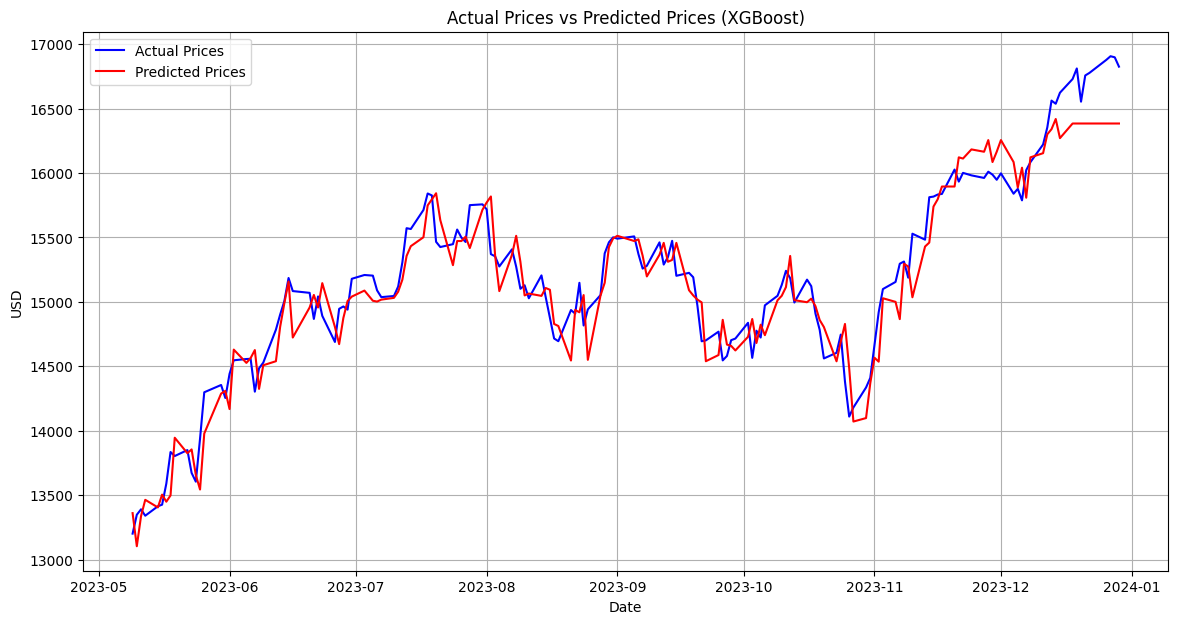

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('data/nasdaq100_data.csv')

# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter data to the specified end date
start_date = '2020-10-02'
end_date = '2023-12-29'
data_filtered = data.loc[start_date:end_date]

# Extract the prices and create lag features
data_filtered['Close_Lag1'] = data_filtered['Close'].shift(1)
data_filtered['Close_Lag2'] = data_filtered['Close'].shift(2)
data_filtered['Close_Lag3'] = data_filtered['Close'].shift(3)

# Drop NaN values from lag features
data_filtered.dropna(inplace=True)

# Features and target variable
X = data_filtered[['Close_Lag1', 'Close_Lag2', 'Close_Lag3']]
y = data_filtered['Close']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create and train the XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.2, max_depth=5)
model.fit(X_train, y_train)

# Predicting on test data
predictions = model.predict(X_test)



# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(data_filtered.index[-len(y_test):], y_test, label='Actual Prices', color='blue')
plt.plot(data_filtered.index[-len(predictions):], predictions, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Actual Prices vs Predicted Prices (XGBoost)')
plt.grid(True)
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# สมมุติว่า 'actual_prices' คือราคาจริงและ 'predicted_prices' คือราคาที่โมเดลทำนาย
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error: 42670.486218674785
Root Mean Squared Error (RMSE): 206.56835725414186
